In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


# Assignment 2: Time Series

Laleu Alexandre

The purpose of this work is to compare different methods for predicting weather data (temperature and precipitation) in Barcelona in 2022.

## Opening the dataset

Importing useful librairies and metrics.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
import numpy as np
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV


Opening the data with date column as a datetime index.

In [3]:
df = pd.read_csv('C:/Users/laleu/OneDrive/Documents/2A/IA/Assignment2/weather_bcn.csv', parse_dates=["time"], index_col="time")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1990-01-01 to 2022-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    396 non-null    float64
 1   tmin    394 non-null    float64
 2   tmax    394 non-null    float64
 3   prcp    393 non-null    float64
 4   pres    373 non-null    float64
dtypes: float64(5)
memory usage: 18.6 KB


## Temperatures predictions

We select the average temperature column to obtain a one-column time series format.
We will use the data from year 2022 as test data.

In [4]:
tavg_series = df[["tavg"]]

train = tavg_series.loc[:'2021-12-31']
test = tavg_series.loc['2022-01-01':]

We plot the data.

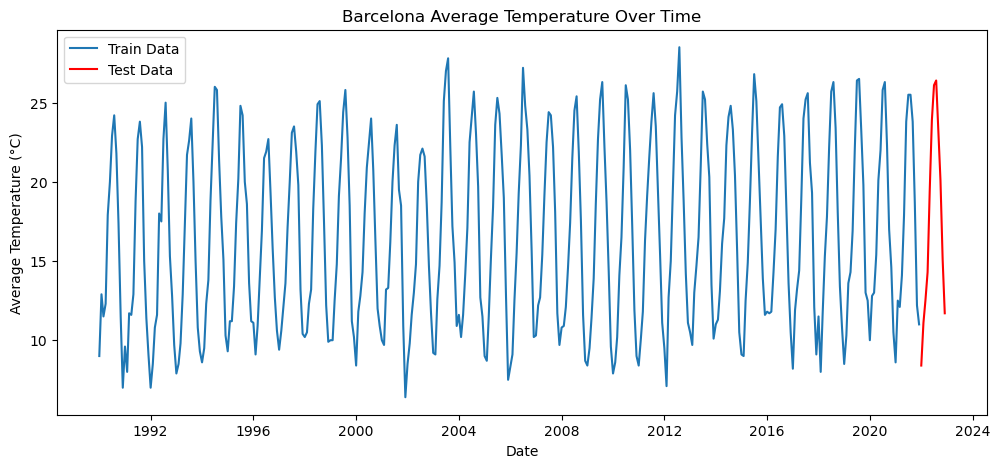

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color='red')
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.title("Barcelona Average Temperature Over Time")
plt.legend()
plt.show()

### Apllying auto_arima with seasonality

Analyzing the time series into trend, seasonality and residuals.

As the data is measured every month, we assume a 12 month period recognition.
Also we can understand that the time serie follows more an additive model rather than a multiplicative model.

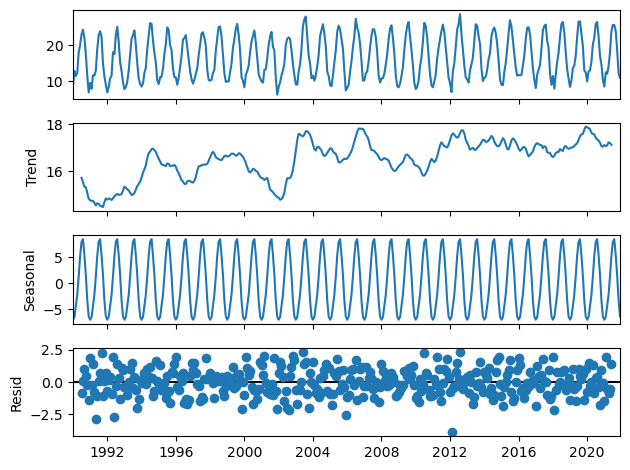

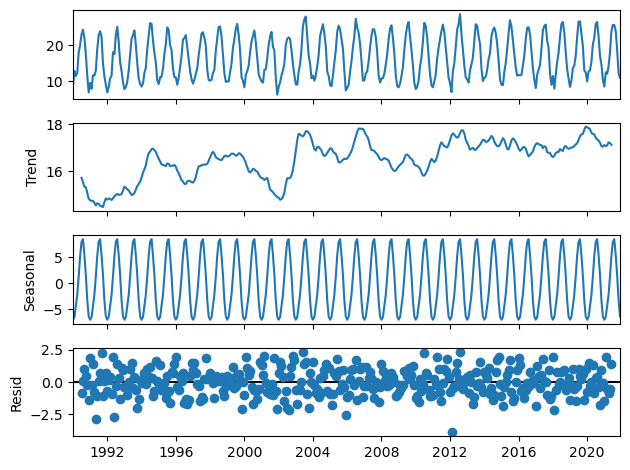

In [6]:
result = seasonal_decompose(train, model='additive', period=12)
result.plot()

We actually observe the 12-months seasonality as expected.
Furthermore, the trend shows that temperatures tend to increase.

Let's check if the data is stationnary in order to apply auto_arima.
We apply the statistical test of Augmented Dickey-Fuller (ADF) to verify it.

We will consider that the data is stationnary if:
-  p-value < 0.05 
- ADF test statistic < min(ADF critical values)

In [7]:
adf = adfuller(train)
print('ADF test statistic:', adf[0])

ADF test statistic: -3.4580359422843365


In [8]:
print('ADF p-values:', adf[1])

ADF p-values: 0.009132537104876203


In [9]:
print('ADF critical values:', adf[4])

ADF critical values: {'1%': -3.448343869853195, '5%': -2.869469418606909, '10%': -2.570994248260623}


The data is considered stationnary.

Let's apply auto_arima.

- stepwise will find automaticly the best parameters
- trace will print every steps
- as the seasonality has monthly patterns, we must set m = 12

In [10]:
model = pm.auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1408.356, Time=2.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2430.316, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1847.441, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3288.363, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1421.576, Time=2.15 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=1302.089, Time=4.58 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=1361.733, Time=5.47 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=7.98 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=1377.081, Time=5.72 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=1309.002, Time=6.93 sec
 ARIMA(3,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=10.85 sec
 ARIMA(2,0,3)(2,0,1)[12] intercept   : AIC=

The best parameters found are: 
- p = 1 as Auto Regressive component
- d = 0 (coherent with the fact that the time serie is stationnary)
- q = 0 as Moving Average component

We forecast the 2022 temperatures in a Panda Series.

In [11]:
n_test = len(test)
forecast, conf_int = model.predict(n_test, return_conf_int=True)

forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)

We plot the results.

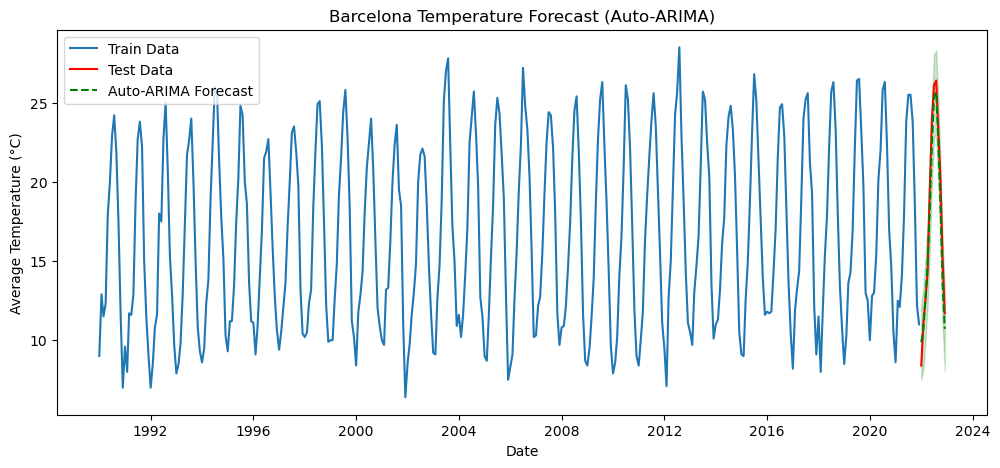

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color='red')
plt.plot(forecast_series, label="Auto-ARIMA Forecast", color='green', linestyle="dashed")
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.title("Barcelona Temperature Forecast (Auto-ARIMA)")
plt.legend()
plt.show()

The shape is good, but the model seems to predict to high temperatures variations.

Let's look at the metrics. 

We introduce a function that compute all the relevant metrics in order to save time. We will use this function all over the script.

In [13]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    explained_variance = explained_variance_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MSE": mse, "MAPE": mape, "R2": r2, "Explained Variance": explained_variance}

print(evaluate(test.squeeze(), forecast_series))


{'MAE': 0.9534917637007152, 'RMSE': 1.0725430751932723, 'MSE': 1.1503486481450416, 'MAPE': 6.071879659158234, 'R2': 0.9682660010166964, 'Explained Variance': 0.9782785817807604}


### Applying auto_arima without seasonality

In [14]:
model_2 = pm.auto_arima(train, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1471.493, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2430.316, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1969.725, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2055.205, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3288.363, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1766.252, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1495.057, Time=0.91 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1498.843, Time=1.78 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1819.456, Time=0.41 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1695.751, Time=0.69 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1481.231, Time=1.71 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1778.104, Time=0.56 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] interc

The best parameters found are very different: 
- p = 2 as Auto Regressive component
- d = 0 (coherent with the fact that the time serie is stationnary)
- q = 2 as Moving Average component

We also notice that the time that the algorithm takes to create the model is shorter.

We run the new forecasts:

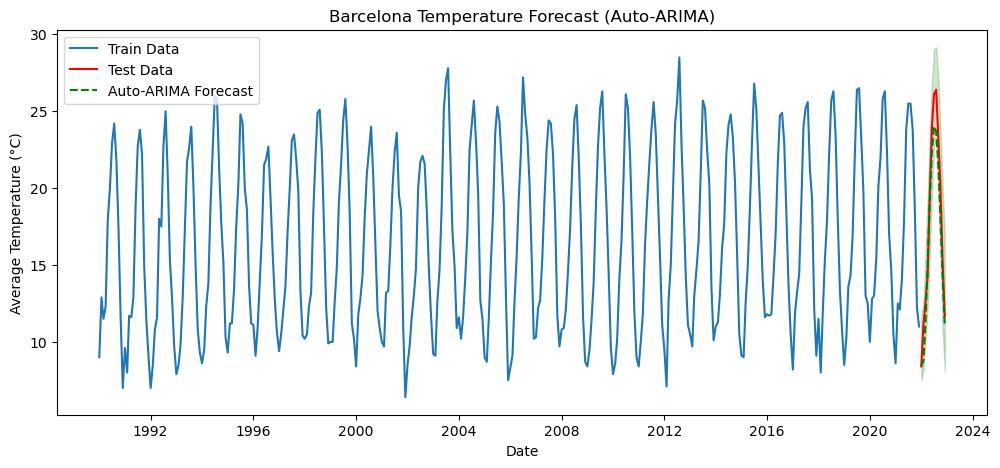

In [15]:
forecast_2, conf_int_2 = model_2.predict(n_test, return_conf_int=True)

forecast_index_2 = test.index
forecast_series_2 = pd.Series(forecast_2, index=forecast_index_2)

plt.figure(figsize=(12, 5))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color='red')
plt.plot(forecast_series_2, label="Auto-ARIMA Forecast", color='green', linestyle="dashed")
plt.fill_between(forecast_index_2, conf_int[:, 0], conf_int_2[:, 1], color='green', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.title("Barcelona Temperature Forecast (Auto-ARIMA)")
plt.legend()
plt.show()

It seems that the model forcasts even more higher temperatures. Let's compare the performances.

In [16]:
results_1 = evaluate(test.squeeze(), forecast_series)
results_2 = evaluate(test.squeeze(), forecast_series_2)

print("Model's performances with seasonality:")
for k, v in results_1.items():
    print(f"{k}: {v}")

print("\nModel's performances without seasonality:")
for k, v in results_2.items():
    print(f"{k}: {v}")

Model's performances with seasonality:
MAE: 0.9534917637007152
RMSE: 1.0725430751932723
MSE: 1.1503486481450416
MAPE: 6.071879659158234
R2: 0.9682660010166964
Explained Variance: 0.9782785817807604

Model's performances without seasonality:
MAE: 1.3774208407854065
RMSE: 1.60418233293085
MSE: 2.5734009572874648
MAPE: 7.738280295769673
R2: 0.9290090847727962
Explained Variance: 0.973587660498494


The seasonality model has better performances in every metrics. That is coherent because temperautres are highly linked with periodicity.

The Mean Absolute Error and the Root Mean Squared Error show a difference of 1 degree in average. Which is not bad but not negligible in long term predictions. As the Mean Absolute Percentage Error explains, this difference represents 6% of the actual temperatures.

However, the R2 and the explained variance convey quite a good prediction of the variance of the data.

### Applying Exponential Smoothing method

c:\Users\laleu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


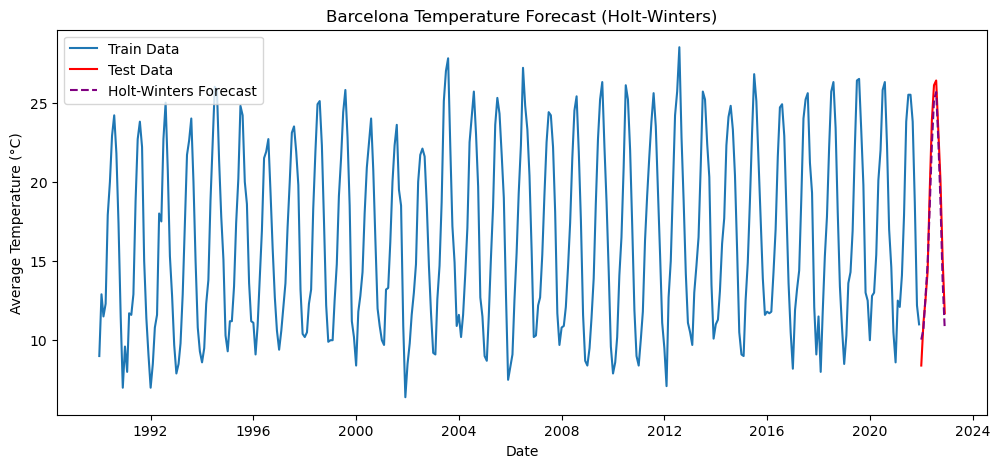

In [17]:
hw_model = ExponentialSmoothing(train.squeeze(), seasonal='add', trend='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(len(test))
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data', color='red')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='purple', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.title("Barcelona Temperature Forecast (Holt-Winters)")
plt.legend()
plt.show()

Here it's kind of the opposite, the higher temperatures are well predicted while the lower ones are not as well predicted. But, in overall, the result seems better.

Let's verify with the metrics:

In [18]:
results_hw = evaluate(test.squeeze(), hw_forecast)

print("Model's performances with seasonality:")
for k, v in results_1.items():
    print(f"{k}: {v}")

print("\nModel's performances with exponential smoothing:")
for k, v in results_hw.items():
    print(f"{k}: {v}")

Model's performances with seasonality:
MAE: 0.9534917637007152
RMSE: 1.0725430751932723
MSE: 1.1503486481450416
MAPE: 6.071879659158234
R2: 0.9682660010166964
Explained Variance: 0.9782785817807604

Model's performances with exponential smoothing:
MAE: 0.9471353061821907
RMSE: 1.0507707724372872
MSE: 1.1041192162084534
MAPE: 6.1259721521499575
R2: 0.9695413054632569
Explained Variance: 0.9782617493880116


Results are very similar, statisticly speaking: good prediction of the variance but still a 1 degree difference, which is not bad but no negligible.

### Regression model

We first have to convert the data into a classical tabular format by using lag features:

In [19]:
lags = 12
df_tavg = tavg_series.copy()

for lag in range(1, lags + 1):
    df_tavg[f"lag_{lag}"] = df_tavg["tavg"].shift(lag)

lagged_df = df_tavg.dropna()

train = lagged_df.loc[:'2021-12-31']
test = lagged_df.loc['2022-01-01':]

X_train = train.drop(columns=["tavg"])
y_train = train["tavg"]
X_test = test.drop(columns=["tavg"])
y_test = test["tavg"]

print(lagged_df)

            tavg  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
time                                                                       
1991-01-01   9.6    7.0   11.5   17.4   21.8   24.2   22.9   20.0   17.9   
1991-02-01   8.0    9.6    7.0   11.5   17.4   21.8   24.2   22.9   20.0   
1991-03-01  11.7    8.0    9.6    7.0   11.5   17.4   21.8   24.2   22.9   
1991-04-01  11.6   11.7    8.0    9.6    7.0   11.5   17.4   21.8   24.2   
1991-05-01  12.9   11.6   11.7    8.0    9.6    7.0   11.5   17.4   21.8   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-08-01  26.4   26.1   23.9   19.4   14.3   12.5   11.1    8.4   11.0   
2022-09-01  23.2   26.4   26.1   23.9   19.4   14.3   12.5   11.1    8.4   
2022-10-01  20.1   23.2   26.4   26.1   23.9   19.4   14.3   12.5   11.1   
2022-11-01  15.1   20.1   23.2   26.4   26.1   23.9   19.4   14.3   12.5   
2022-12-01  11.7   15.1   20.1   23.2   26.4   26.1   23.9   19.4   14.3   

           

Here we will use a k-nn regressor algorithm on which we will try to find the best hyperparameters using a grid-search method with Manhattan and Euclidian distances.

Findin the best hyperparameters:

In [20]:
param_grid = {
    'n_neighbors': [2, 3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print(grid_search.best_params_)

{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


Predicting:

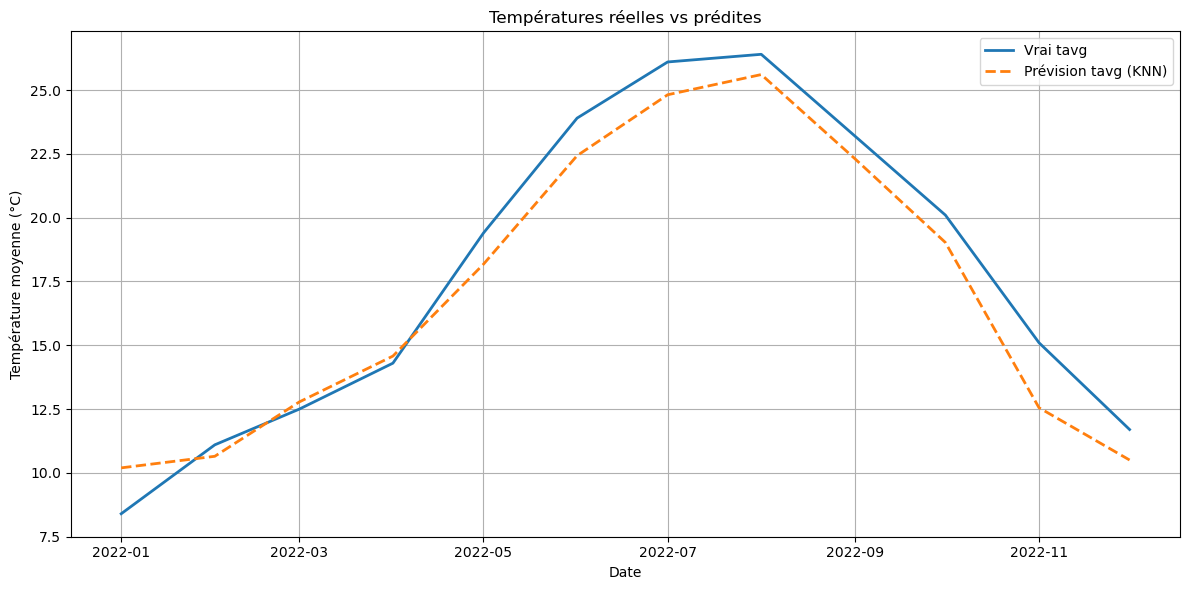

In [21]:
y_pred = best_knn.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Vrai tavg", linewidth=2)
plt.plot(y_test.index, y_pred, label="Prévision tavg (KNN)", linestyle='--', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Température moyenne (°C)")
plt.title("Températures réelles vs prédites")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
print(evaluate(y_test, y_pred))

{'MAE': 1.1067978631249706, 'RMSE': 1.2709893274263044, 'MSE': 1.61541387043157, 'MAPE': 7.189445316439114, 'R2': 0.955436517264089, 'Explained Variance': 0.9695034314461781}


Here again, the results are kind of the same, even slightly less accurate than with auto_arima...

## Precipitations predictions

In [23]:
df = pd.read_csv('C:/Users/laleu/OneDrive/Documents/2A/IA/Assignment2/weather_bcn.csv', parse_dates=["time"], index_col="time")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1990-01-01 to 2022-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    396 non-null    float64
 1   tmin    394 non-null    float64
 2   tmax    394 non-null    float64
 3   prcp    393 non-null    float64
 4   pres    373 non-null    float64
dtypes: float64(5)
memory usage: 18.6 KB


We apply the same methods to forecast precipitations.

In [24]:
prcp_series = df[["prcp"]]

train = prcp_series.loc[:'2021-12-31']
test = prcp_series.loc['2022-01-01':]

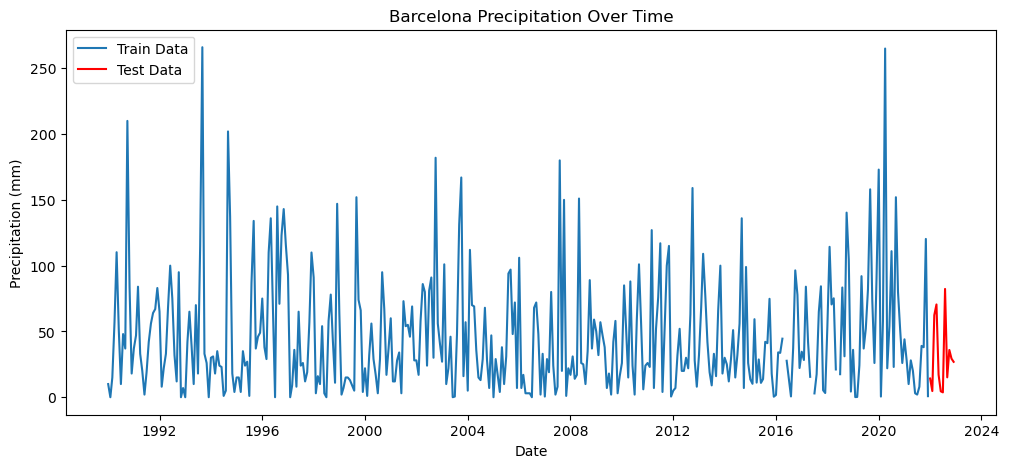

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color='red')
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Barcelona Precipitation Over Time")
plt.legend()
plt.show()

### Apllying auto_arima with seasonality

Deleting rows with missing data and analyzing seasonality:

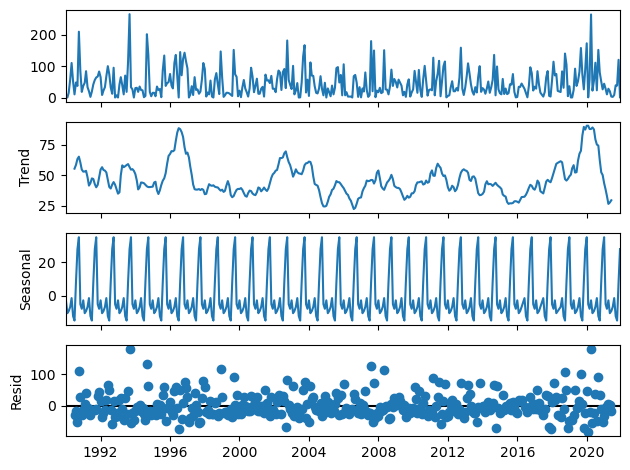

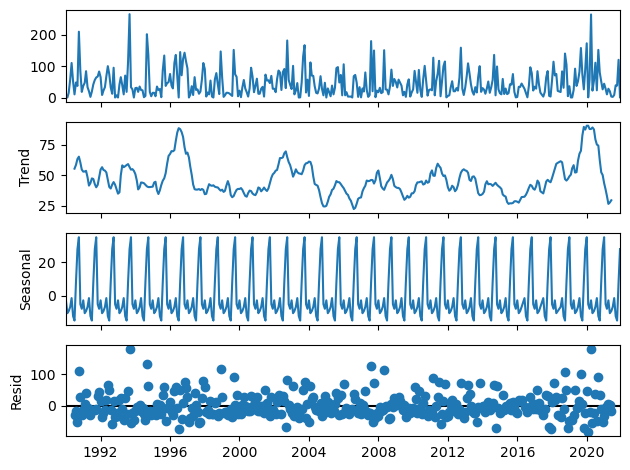

In [26]:
train_clean = train.dropna()
result = seasonal_decompose(train_clean, model='additive', period=12)
result.plot()

Here the trend more chaotic and we still have a 12-months seasonality. Moreover, the residuals are way bigger than for temperatures.

Let's analyze if the data is stationnary

In [27]:
adf = adfuller(train_clean)
print('ADF test statistic:', adf[0])

ADF test statistic: -16.709706136036328


In [28]:
print('ADF p-values:', adf[1])

ADF p-values: 1.438043789210446e-29


In [29]:
print('ADF critical values:', adf[4])

ADF critical values: {'1%': -3.4476763783532585, '5%': -2.869176103659426, '10%': -2.570837873961219}


Here also, the data can be considered stationnary.

We apply the model with the best parameters found automatically

In [30]:
model_prcp = pm.auto_arima(train_clean, seasonal=True, m=12, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3959.956, Time=4.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3968.874, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3955.120, Time=1.37 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3955.186, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4247.550, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3962.258, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=3956.044, Time=4.78 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=3956.130, Time=0.70 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=3957.984, Time=4.53 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=3960.283, Time=0.86 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=3955.477, Time=1.91 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=3955.904, Time=1.07 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3954.269, Time=0.90 sec
 ARIMA(0,0,1)(0,0,0)[12]

c:\Users\laleu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\laleu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


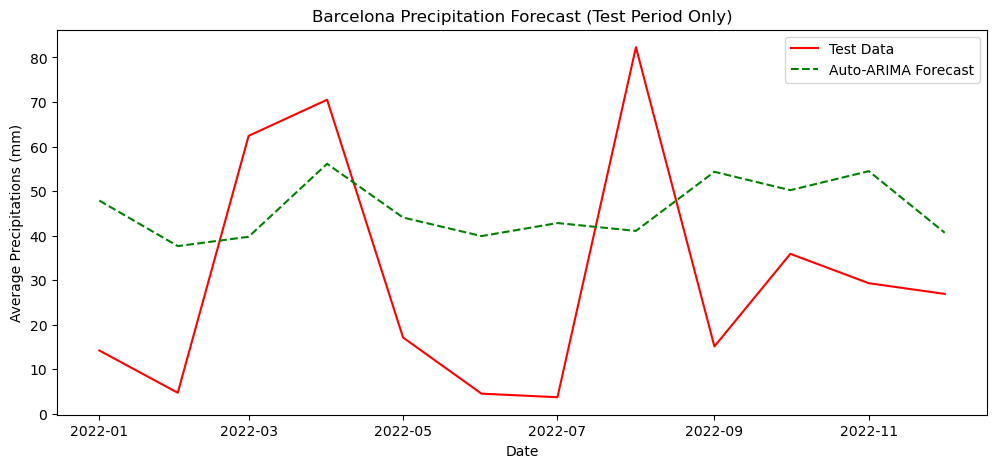

In [31]:
test_clean = test.dropna()

n_test = len(test_clean)
forecast, conf_int = model_prcp.predict(n_test, return_conf_int=True)

forecast_index = test.index[-n_test:]

plt.figure(figsize=(12, 5))
plt.plot(test, label="Test Data", color='red')
plt.plot(forecast_index, forecast, label="Auto-ARIMA Forecast", color='green', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Average Precipitations (mm)")
plt.title("Barcelona Precipitation Forecast (Test Period Only)")
plt.legend()
plt.show()


The predictions are less accurate than those for temperatures, but they still provide kind of an average of the order of magnitude of the precipitation.

In [32]:
print(evaluate(test.squeeze(), forecast))

{'MAE': 28.2308241721019, 'RMSE': 29.879339121212766, 'MSE': 892.7749063204357, 'MAPE': nan, 'R2': -0.3248097023676282, 'Explained Variance': 0.017253629265850168}


C:\Users\laleu\AppData\Local\Temp\ipykernel_484\3882311097.py:5: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


The metrics confirm that the predictions are not really accurate.

### Applying autoarima() without seasonality

In [33]:
model_prcp2 = pm.auto_arima(train_clean, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3965.725, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3968.874, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3962.258, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3961.105, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4247.550, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3962.719, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3962.500, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3964.338, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4143.898, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.342 seconds


c:\Users\laleu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\laleu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


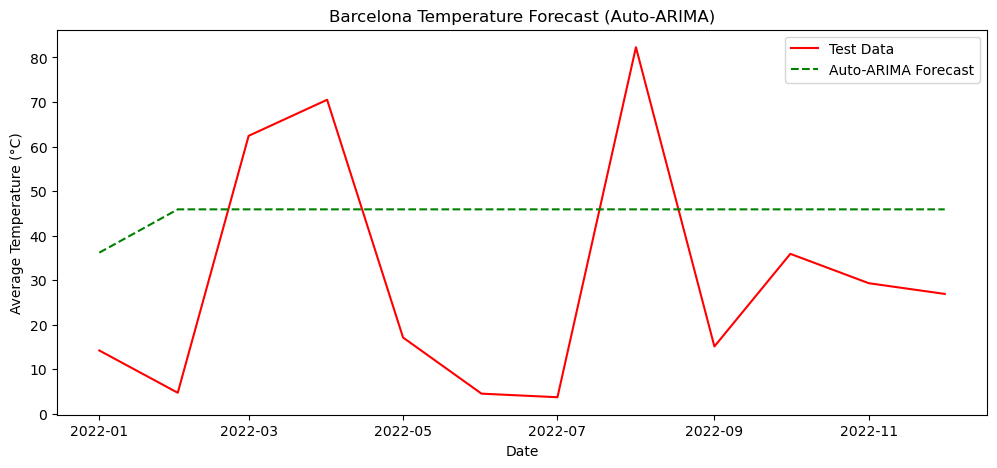

In [34]:
forecast_2, conf_int_2 = model_prcp2.predict(n_test, return_conf_int=True)

forecast_index_2 = test.index[-n_test:]

plt.figure(figsize=(12, 5))
plt.plot(test_clean, label="Test Data", color='red')
plt.plot(forecast_index_2, forecast_2, label="Auto-ARIMA Forecast", color='green', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.title("Barcelona Temperature Forecast (Auto-ARIMA)")
plt.legend()
plt.show()


Without seasonality, the result is very weird. It predicts only the average precipitation over the year.

In [35]:
print(evaluate(test_clean.squeeze(), forecast_series_2))

{'MAE': 22.547994092311438, 'RMSE': 29.967084517476575, 'MSE': 898.0261544775843, 'MAPE': 126.52648892752094, 'R2': -0.332602153139798, 'Explained Variance': -0.035996402232472136}


Metrics show that the predictions are way worst than with seasonality.

### Applying Exponential Smoothing method

c:\Users\laleu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\laleu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\laleu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


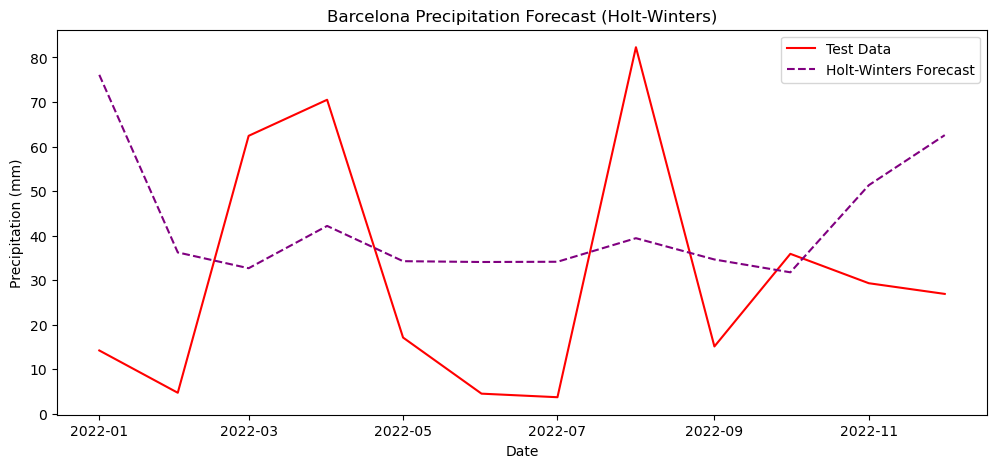

In [36]:
hw_model = ExponentialSmoothing(train_clean.squeeze(), seasonal='add', trend='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(len(test))
hw_forecast.index = test.index 

plt.figure(figsize=(12, 5))
plt.plot(test_clean, label='Test Data', color='red')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='purple', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Barcelona Precipitation Forecast (Holt-Winters)")
plt.legend()
plt.show()

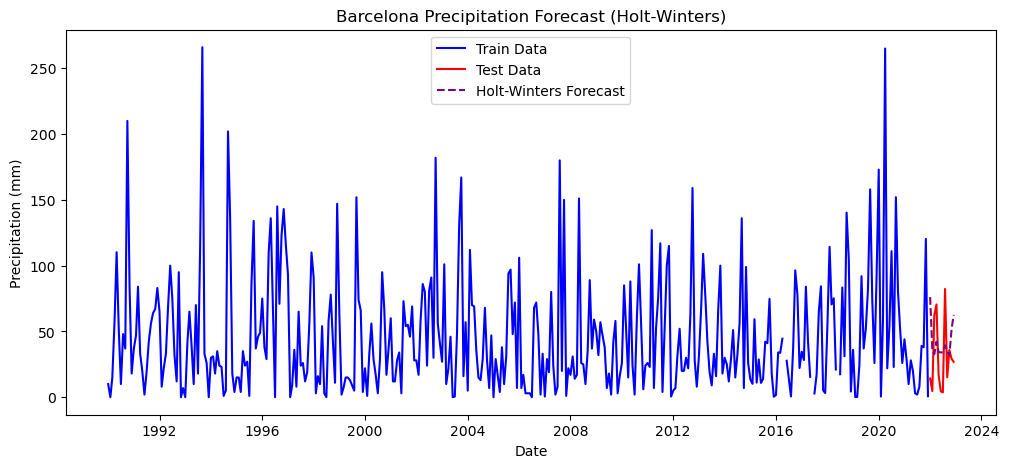

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train Data', color='blue')
plt.plot(test, label='Test Data', color='red')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='purple', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Barcelona Precipitation Forecast (Holt-Winters)")
plt.legend()
plt.show()

In [38]:
print(evaluate(test_clean.squeeze(), forecast_series_2))

{'MAE': 22.547994092311438, 'RMSE': 29.967084517476575, 'MSE': 898.0261544775843, 'MAPE': 126.52648892752094, 'R2': -0.332602153139798, 'Explained Variance': -0.035996402232472136}


Here again the result is kinf of an average and not very accurate when predicting the variance.

### Regression model

The same procedure is followed. We just add the pression as an additional feature.

In [39]:
lags = 12
prcp_series2 = df[["prcp","pres"]]
df_prcp = prcp_series2.copy()

for lag in range(1, lags + 1):
    df_prcp[f"lag_{lag}"] = df_prcp["prcp"].shift(lag)

lagged_df = df_prcp.dropna()

train = lagged_df.loc[:'2021-12-31']
test = lagged_df.loc['2022-01-01':]

X_train = train.drop(columns=["prcp"])
y_train = train["prcp"]
X_test = test.drop(columns=["prcp"])
y_test = test["prcp"]

print(lagged_df)

            prcp    pres  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  \
time                                                                        
1991-01-01  37.0  1021.8   18.0   84.0  210.0   37.0   48.0   10.0   51.0   
1991-02-01  47.0  1015.5   37.0   18.0   84.0  210.0   37.0   48.0   10.0   
1991-03-01  84.0  1010.1   47.0   37.0   18.0   84.0  210.0   37.0   48.0   
1991-04-01  33.0  1015.1   84.0   47.0   37.0   18.0   84.0  210.0   37.0   
1991-05-01  20.0  1014.7   33.0   84.0   47.0   37.0   18.0   84.0  210.0   
...          ...     ...    ...    ...    ...    ...    ...    ...    ...   
2022-08-01  82.3  1013.9    3.7    4.5   17.1   70.5   62.4    4.7   14.2   
2022-09-01  15.1  1013.6   82.3    3.7    4.5   17.1   70.5   62.4    4.7   
2022-10-01  35.9  1020.6   15.1   82.3    3.7    4.5   17.1   70.5   62.4   
2022-11-01  29.3  1016.9   35.9   15.1   82.3    3.7    4.5   17.1   70.5   
2022-12-01  26.9  1015.5   29.3   35.9   15.1   82.3    3.7    4.5   17.1   

In [40]:
param_grid = {
    'n_neighbors': [2, 3, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print(grid_search.best_params_)

{'n_neighbors': 17, 'p': 1, 'weights': 'distance'}


So, according to this grid search, our model will use the Manhattan metric and the first 16 neighbors to make predictions.
The large number of neighbors might indicate that the predictions are very difficult to make accurately.

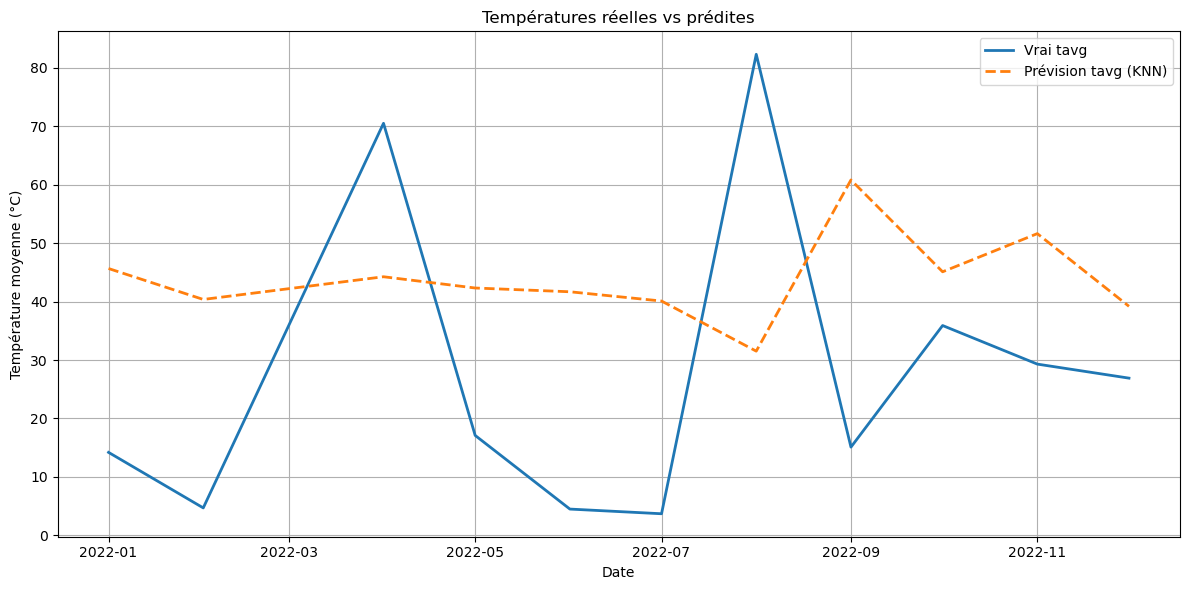

In [41]:
y_pred = best_knn.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Vrai tavg", linewidth=2)
plt.plot(y_test.index, y_pred, label="Prévision tavg (KNN)", linestyle='--', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Température moyenne (°C)")
plt.title("Températures réelles vs prédites")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Here again, all the variations are not well predicted.

In [42]:
print(evaluate(y_test.squeeze(), y_pred))

{'MAE': 30.22247410324237, 'RMSE': 32.605694419510435, 'MSE': 1063.131308578494, 'MAPE': 316.9551904358902, 'R2': -0.6754152867076293, 'Explained Variance': -0.2610427018445376}


Once again, the relative mean squared error is approximately 30%, which remains high. Additionally, the model still fails to capture the variance effectively.

## Conclusion

This work illustrates how different time series forecasting methods operate. Although their predictions are relatively similar, achieving high accuracy remains somewhat affected by seasonal patterns.

Overall, the precipitation forecasts—whose variations are more chaotic compared to temperature—highlight the limitations of relying solely on past precipitation values. Furthermore, adding atmospheric pressure as an additional feature appears to have only a limited effect on improving both accuracy and the model's ability to capture variability.

